In [7]:
import numpy as np
import matplotlib.pyplot as plt
from napari_flim_phasor_plotter import _synthetic as syn
from scipy.stats import norm
from scipy import signal

## GT Single Lifetime

In [1]:
def calculate_exp(x, A, tau):
    import numpy as np
    if np.isscalar(tau):
        tau = np.array([tau])
        A = np.array([A])
    return np.sum(A[:, None] * np.exp(-1/tau[:, None]*x), axis = 0)

In [3]:
laser_frequency = 40 # MHz
number_of_time_points = 300
small_time_array = syn.create_time_array(laser_frequency,number_of_time_points)

tau_1 = 0.7
tau_2 = 2
a1 = 1
two_amplitudes = np.array([a1, 1-a1])
tau_array = np.array([tau_1,tau_2])

In [4]:
normalized_counts = calculate_exp(small_time_array, two_amplitudes, tau_array)

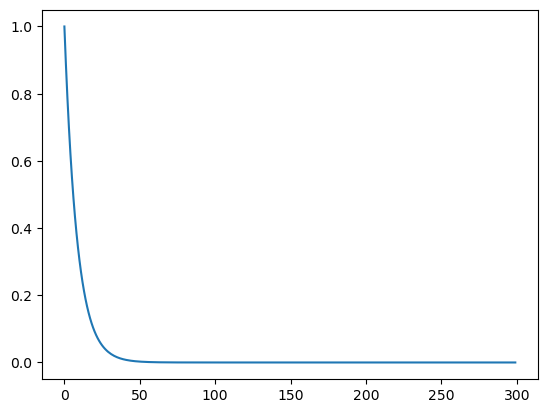

In [6]:
plt.plot(normalized_counts)

## GT IRF

In [8]:
sigma = 0.2 #ns
offset = 3*sigma

In [26]:
syn_irf = norm.pdf(small_time_array, loc = offset, scale = sigma)

syn_irf = syn_irf/np.max(syn_irf)

syn_irf = syn_irf[:16]

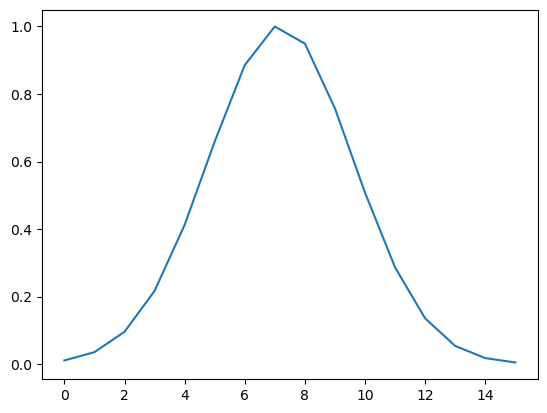

In [27]:
plt.plot(syn_irf)

## Convolution

In [28]:
from scipy.signal import convolve

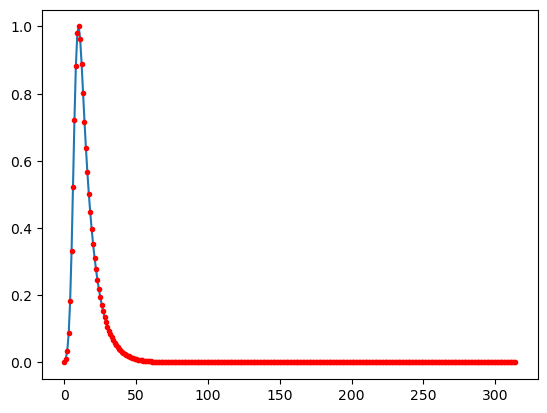

In [35]:
lifetime_signal = convolve(normalized_counts, syn_irf, mode='full')
lifetime_signal = lifetime_signal/np.max(lifetime_signal)
plt.plot(lifetime_signal, '.-', mfc='red', mec = 'red')

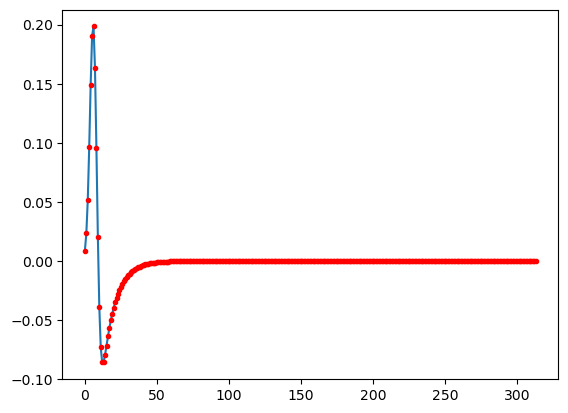

In [37]:
d_lifetime_signal = np.diff(lifetime_signal)
plt.plot(d_lifetime_signal, '.-', mfc='red', mec = 'red')


In [39]:
np.argmax(d_lifetime_signal)

6

In [40]:
np.amax(d_lifetime_signal)

0.19838337533750683

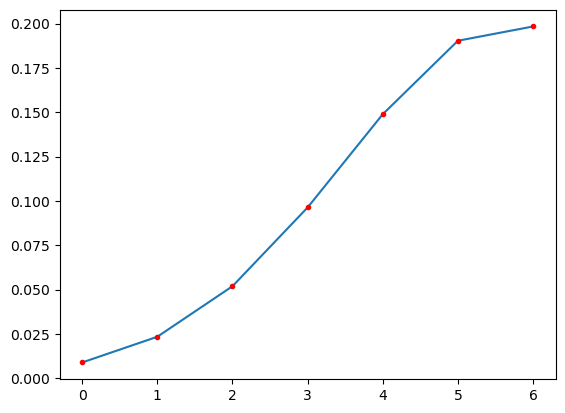

In [42]:
d_lifetime_signal_rise = d_lifetime_signal[:np.argmax(d_lifetime_signal)+1]
plt.plot(d_lifetime_signal_rise, '.-', mfc='red', mec = 'red')

In [43]:
syn_irf_rebuilt = d_lifetime_signal_rise   d_lifetime_signal_rise[1::-1]

array([0.00884713, 0.02335031, 0.05184114, 0.09627527, 0.14887464,
       0.19033452, 0.19838338])

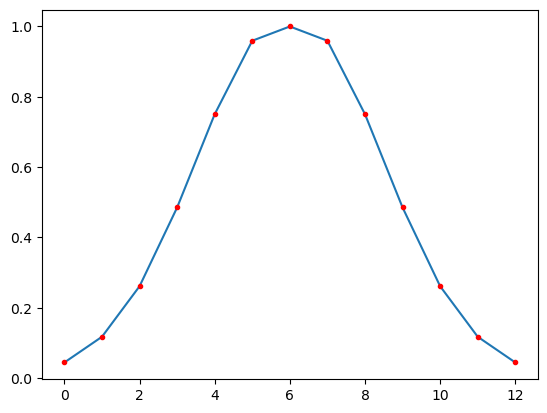

In [63]:
syn_irf_rebuilt = np.concatenate((d_lifetime_signal_rise, d_lifetime_signal_rise[::-1][1:]))
syn_irf_rebuilt /= np.amax(syn_irf_rebuilt)
plt.plot(syn_irf_rebuilt, '.-', mfc='red', mec = 'red')

## Deconvolve
Fix code below

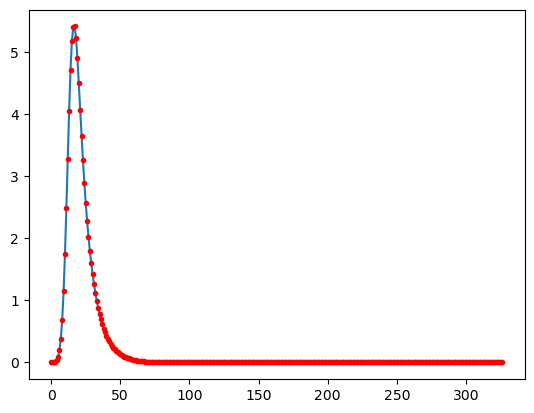

In [64]:
lifetime_signal_rebuilt = convolve(lifetime_signal, syn_irf_rebuilt, mode='full')
plt.plot(lifetime_signal_rebuilt, '.-', mfc='red', mec = 'red')